In [1]:
import numpy as np
import matplotlib.pyplot as plt

from CADMium import Pssolver
from CADMium import Psgrid
from CADMium import Partition
from CADMium import Inverter

a = 4.53534/2
#Nuclear charge for fragments A and B
Za, Zb = 2,2
#Set polarization 1-Unpolarized, 2-Polarized
pol = 1
#Fragment a electrons [alpha, beta]
Nmo_a = [[1]] #Number of molecular orbitals to calculate
N_a   = [[2]]
#Ensemble mix
nu_a = 1
#Fragment b electrons
Nmo_b = [[1]]
N_b   = [[2]]
#Ensemble mix
nu_b = 1

#Molecular elctron configuration
Nmo_m = [[2]]
N_m   = [[4]]

#Set up grid
NP = 7
NM = [4,4]
L = np.arccosh(15/a)
loc = np.array(range(-4,5)) #Stencil outline

grid = Psgrid(NP, NM, a, L, loc)
grid.initialize()


In [2]:
part = Partition(grid, Za, Zb, pol, Nmo_a, N_a, nu_a, Nmo_b, N_b, nu_b, {"kinetic_part_type" : "inversion", 
                                                                         "ab_sym"            : True,
                                                                         "ens_spin_sym"      : False})
#Make initial guess out of isolated fragments
part.optPartition.isolated = True
part.scf({"disp"   : True,
          "alpha"  : [0.6], 
           "e_tol" : 1e-6})

                Total Energy ( a.u.)                               Inversion                

                __________________                ____________________________________     

Iteration         A              B                  iters      optimality        res       

___________________________________________________________________________________________ 

    1           -3.46527     -3.46527       1.000e+00 
    2           -2.92002     -2.92002       2.199e-01 
    3           -2.84920     -2.84920       2.940e-02 
    4           -2.83801     -2.83801       4.671e-03 
    5           -2.83583     -2.83583       9.103e-04 
    6           -2.83528     -2.83528       2.546e-04 
    7           -2.83511     -2.83511       9.720e-05 
    8           -2.83505     -2.83505       3.794e-05 
    9           -2.83503     -2.83503       1.493e-05 
   10           -2.83502     -2.83502       5.894e-06 
   11           -2.83502     -2.83502       2.329e-06 
   12           -2.83

In [3]:
#Setup inverter object. 
mol_solver = Pssolver(grid, Nmo_m, N_m)
wy = Inverter(grid, mol_solver, {"disp"          : True,
                                 #Needs to work with orbitalinvert too
                                 "invert_type"   : "wuyang", 
                                 "use_iterative" : True,
                                 "avoid_loop"    : True,
                                 "ab_sym"        : True,
                                 "ens_spin_sym"  : False})
#Define target density
nf = part.nf
phi0, e0, v0 = part.initialguessinvert(ispin=0)
 #It appears that phi prints an array that is twice the 
 #Size in shoud be
 #Even though wuyang accepts the larger phi. Oribtal ivnert is unhappy with the too long phi
print(phi0.shape)
print(nf.shape)

(1250, 1)
(625, 1)


In [4]:
#Generate intial guess from inverter
sucess, inv_info = wy.invert( nf, v0, phi0[:625,:], e0 )

#If successful, extract components for solver. 
phi = wy.solver[0][0].phi
evs = wy.solver[0][0].eig
vs  = wy.vs[:,0]

In [5]:
#Plot kohn sham potential
full, x,y = grid.plotter(vs)
x_axis,vp = grid.axis_plot(vs)
# plt.plot(x_axis,vp)

In [6]:
#Make forward problem
for i in range(wy.solver.shape[0]):
    for j in range(wy.solver.shape[1]):
        wy.solver[i,j].setveff(vs)
        wy.solver[i,j].calc_orbitals()
        wy.solver[i,j].calc_density()
        n = wy.solver[i,j].n

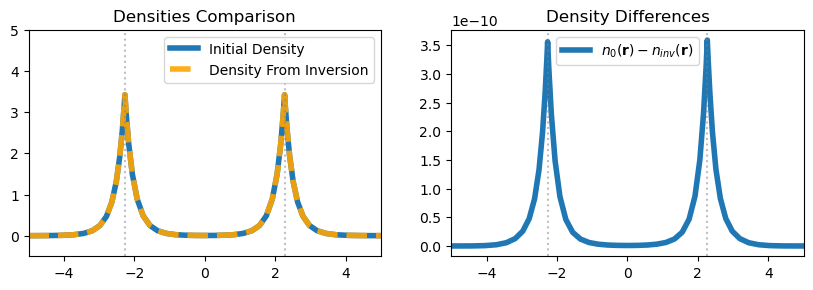

In [7]:
#Plot initial and target density

x_axis, n0   = grid.axis_plot(nf)
x_axis, ninv = grid.axis_plot(n)

fig, ax = plt.subplots(1,2, figsize=(10,3), dpi=100)

#Densities
ax[0].set_title("Densities Comparison")
ax[0].plot(x_axis, n0, label="Initial Density", lw=4)
ax[0].plot(x_axis, ninv, label="Density From Inversion", ls='dashed', color='orange', alpha=0.9, lw=4)
ax[0].set_xlim((-5,5))
ax[0].set_ylim((-0.5,5))
ax[0].axvline(x= 4.53534/2, ls=':', color='grey', alpha=0.5)
ax[0].axvline(x=-4.53534/2, ls=':', color='grey', alpha=0.5)
ax[0].legend()

#Density Error
ax[1].set_title("Density Differences")
ax[1].plot(x_axis, np.abs(n0 - ninv), lw=4, label='$n_0(\mathbf{r}) - n_{inv}(\mathbf{r})$')
ax[1].set_xlim((-5,5))
# ax[1].set_ylim((-0.5,5))
ax[1].axvline(x= 4.53534/2, ls=':', color='grey', alpha=0.5)
ax[1].axvline(x=-4.53534/2, ls=':', color='grey', alpha=0.5)
ax[1].legend()